# Predict Discount Based on Age

In [19]:
from random import randrange, choice
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


## Create Data

In [2]:
sample_size =10000
data_file = f'../data/discount_data_{sample_size}.xlsx'

business_list = ['bar', 'restaurant', 'hotel', 'pharmacy', 'spa', 'airline']


def calculate_discount(age, sex, business_type, is_resident):
    business_discounts = dict()
    business_discounts['restaurant'] = 0.2
    business_discounts['pharmacy'] = 0.2
    business_discounts['hotel'] = 0.25
    
    if sex == 'M' and age >= 64 and is_resident:
        return business_discounts.get(business_type, 0.0)
    elif sex == 'F' and age >= 57 and is_resident:
        return business_discounts.get(business_type, 0.0)
    else:
        return 0.0
    
def build_dataframe(samples):

    data = dict()
    data['sex'] = list()
    data['age'] = list()
    data['business_type'] = list()
    data['discount'] = list()
    data['is_resident'] = list()
    for i in range(samples):
        age = randrange(18, 95, 1)
        sex = choice(['M', 'F'])
        business_type = choice(business_list)
        is_resident =  choice([True, False])
        discount = calculate_discount(age, sex, business_type, is_resident)
        #print(f'{sex} age {age} for {business_type}')
        data['sex'].append(sex)
        data['age'].append(age)
        data['business_type'].append(business_type)
        data['discount'].append(discount)
        data['is_resident'].append(is_resident)

        df = pd.DataFrame.from_dict(data)
    return df
    


In [3]:
if os.path.exists(data_file):
    df = pd.read_excel(data_file)
    print(f'Loaded from {data_file}')
else:
    df = build_dataframe(sample_size)
    df.to_excel(data_file, index=False)
    print(f'Saved to {data_file}')

Loaded from ../data/discount_data_10000.xlsx


In [4]:
print(f'Shape: {df.shape}')
df.head()

Shape: (10000, 5)


,sex,age,business_type,discount,is_resident
0,F,78,bar,0.0,True
1,F,24,bar,0.0,False
2,F,45,bar,0.0,True
3,F,21,pharmacy,0.0,False
4,F,45,pharmacy,0.0,False


## Cleanup


### Separate dependent and independent variables

In [5]:
discounts = df['discount'].copy()
df.drop(columns=['discount',], inplace=True)

print(f'discount shape: {discounts.shape}')

df.head()

discount shape: (10000,)


,sex,age,business_type,is_resident
0,F,78,bar,True
1,F,24,bar,False
2,F,45,bar,True
3,F,21,pharmacy,False
4,F,45,pharmacy,False


### Hot One Encode

In [6]:
df = pd.get_dummies(df, columns=['sex', 'business_type'])


In [7]:


df['is_resident'].replace({False: 0, True: 1}, inplace=True)

### Scaling age

In [23]:
scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df['age'].values.reshape(-1, 1))


[[0.78947368]
 [0.07894737]
 [0.35526316]
 ...
 [0.60526316]
 [0.89473684]
 [0.11842105]]


In [8]:
print(f'Shape: {df.shape}')
df.head()

Shape: (10000, 10)


,age,is_resident,sex_F,sex_M,business_type_airline,business_type_bar,business_type_hotel,business_type_pharmacy,business_type_restaurant,business_type_spa
0,78,1,1,0,0,1,0,0,0,0
1,24,0,1,0,0,1,0,0,0,0
2,45,1,1,0,0,1,0,0,0,0
3,21,0,1,0,0,0,0,1,0,0
4,45,0,1,0,0,0,0,1,0,0


## Basic Neuronal Network


In [9]:
learning_rate = 0.01
input_layer = tf.keras.layers.Dense(units=1, input_shape=[df.shape[1]])
hidden_layer = tf.keras.layers.Dense(units=256)
output_layer = tf.keras.layers.Dense(units=1)

In [10]:
model = tf.keras.models.Sequential()

model.add(input_layer)
model.add(hidden_layer)
model.add(output_layer)


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='mean_squared_error',
    #metrics=['accuracy']
)

In [12]:
history = model.fit(df.values, discounts.values, epochs=20)

Epoch 1/20
313/313 [==============================] - 1s 733us/step - loss: 0.0069
Epoch 2/20
313/313 [==============================] - 0s 773us/step - loss: 0.0033
Epoch 3/20
313/313 [==============================] - 0s 797us/step - loss: 0.0032
Epoch 4/20
313/313 [==============================] - 0s 791us/step - loss: 0.0033
Epoch 5/20
313/313 [==============================] - 0s 792us/step - loss: 0.0033
Epoch 6/20
313/313 [==============================] - 0s 770us/step - loss: 0.0032
Epoch 7/20
313/313 [==============================] - 0s 758us/step - loss: 0.0031
Epoch 8/20
313/313 [==============================] - 0s 752us/step - loss: 0.0031
Epoch 9/20
313/313 [==============================] - 0s 755us/step - loss: 0.0031
Epoch 10/20
313/313 [==============================] - 0s 771us/step - loss: 0.0032
Epoch 11/20
313/313 [==============================] - 0s 775us/step - loss: 0.0031
Epoch 12/20
313/313 [==============================] - 0s 741us/step - loss: 0.0032
E

In [13]:
print(history.history)

{'loss': [0.006869413889944553, 0.0032854846213012934, 0.003162738401442766, 0.0032922797836363316, 0.003289569402113557, 0.00317085231654346, 0.0031385309994220734, 0.003135331440716982, 0.0030684107914566994, 0.003221488557755947, 0.003098523709923029, 0.003195092547684908, 0.003096297150477767, 0.003109806915745139, 0.003133193589746952, 0.003188445931300521, 0.0031461981125175953, 0.0031182041857391596, 0.003070761915296316, 0.003146819304674864]}


<function matplotlib.pyplot.show(close=None, block=None)>

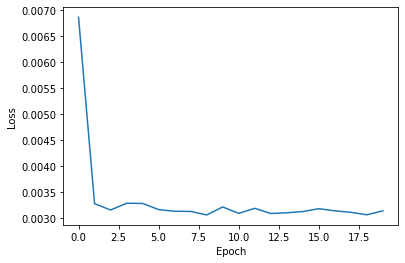

In [14]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.show

In [15]:
df_values = df.values
disc_value = discounts.values

for i in range(500):
    if disc_value[i] > 0.0:
        print(i)
        break

36


In [16]:
print(df_values[36].reshape(1,10))
print(disc_value[36])

[[88  1  1  0  0  0  0  1  0  0]]
0.2


In [17]:
pred = model.predict(df_values[36].reshape(1,10))

print(f'Estimated discount {pred}')

Estimated discount [[0.0992506]]


In [18]:
pred = model.predict(df_values[0].reshape(1,10))

print(f'Estimated discount {pred}')

Estimated discount [[0.05884374]]
